## Visualize Labeled Dataset

- The four corners of each board were labeled for a segmentation task
- Dataset was exported into YOLO format

In [1]:
from glob import glob
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import cv2 

def inner_join(list1, list2, key1, key2):
    joined1, joined2 = [], []
    for i, k1 in enumerate(key1):
        for j, k2 in enumerate(key2):
            if k1 == k2:
                joined1.append(list1[i])
                joined2.append(list2[j])
    return joined1, joined2

DATASET_FOLDER = '/home/garamizo/Datasets/azul_segmentation_finetune/valid'

pathImages = sorted(glob(DATASET_FOLDER + '/images/*'))
pathLabels = sorted(glob(DATASET_FOLDER + '/labels_manual/*'))
pathImages, pathLabels = inner_join(pathImages, pathLabels,
                                    [path.split('/')[-1].split('.')[0] for path in pathImages],
                                    [path.split('/')[-1].split('.')[0] for path in pathLabels])

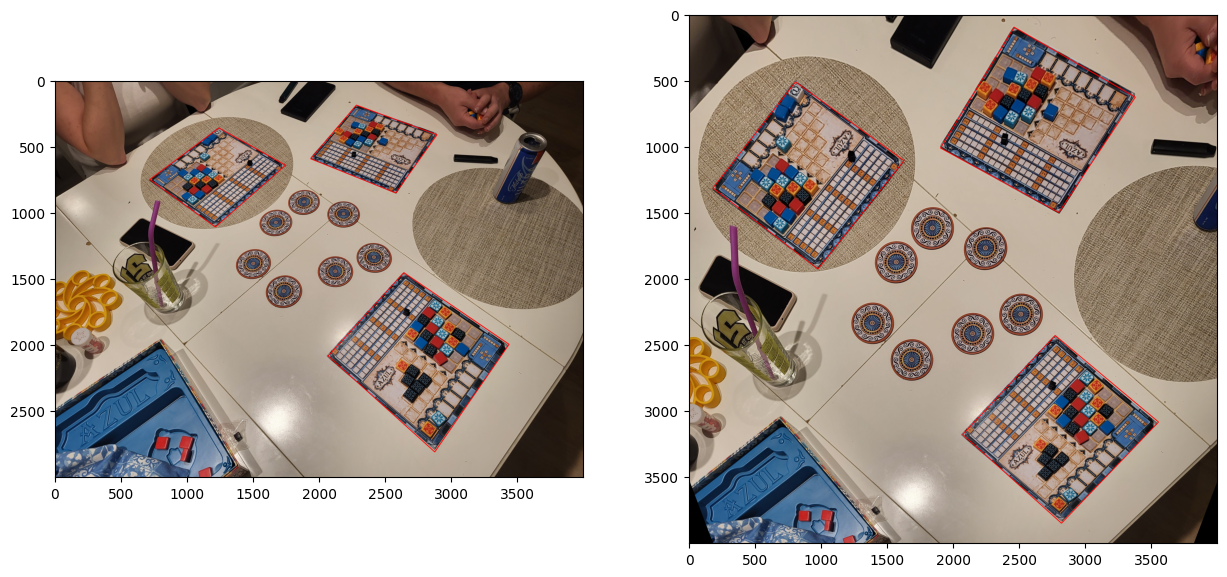

In [2]:
i = 0

img = cv2.imread(pathImages[i])
h, w, c = img.shape

with open(pathLabels[i]) as f:
    pts = []
    for txt in f.readlines():
        strParts = txt.split(' ')[1:]
        numPairs = len(strParts) // 2
        pts.append(np.int32(np.reshape([float(t) for t in strParts[:2*numPairs]], [-1, 2]) * [w, h]))

widthTop = int(w * 0.6)
widthBot = int(w * 1.1)
heightNew = int(h * 0.95)
src = np.float32([
    [w//2 - widthTop//2, h - heightNew],
    [w//2 + widthTop//2, h - heightNew],
    [w//2 + widthBot//2, h],
    [w//2 - widthBot//2, h]])
dst = np.float32([
    [0, 0],
    [w, 0],
    [w, w],
    [0, w]])
shapeOut = (w, w)
mat = cv2.getPerspectiveTransform(src, dst)

imgWarped = cv2.warpPerspective(img, mat, shapeOut)
ptsWarped = cv2.perspectiveTransform(np.float32(pts), mat)

img = cv2.polylines(img, [line for line in pts], True, (0,0,255), 5)
imgWarped = cv2.polylines(imgWarped, [line for line in np.int32(ptsWarped)], True, (0,0,255), 5)

plt.figure(figsize=(15, 8))
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
plt.subplot(122), plt.imshow(cv2.cvtColor(imgWarped, cv2.COLOR_BGR2RGB));
# pts.shape, img.shape

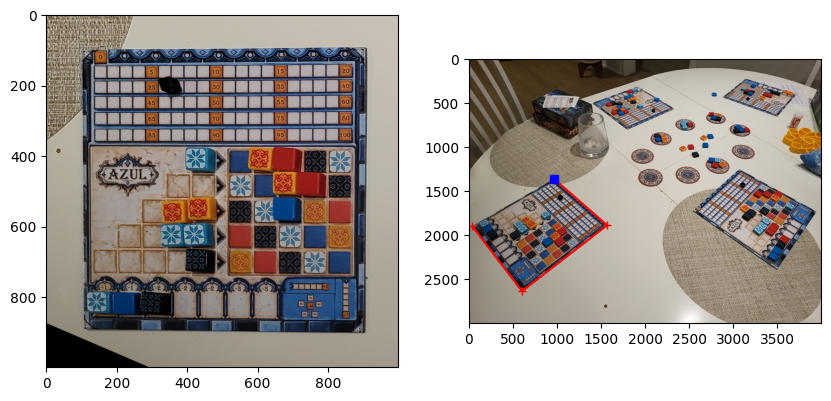

In [3]:
%load_ext autoreload
%autoreload 2
# given label, use ORB to fine tune selection

import azul.vision as vision 
import os

def poly_to_cw(poly):
    # poly is Nx2 
    area = 0.0
    for i, xy in enumerate(poly):
        area += (xy[0] - poly[i-1,0]) * (xy[1] + poly[i-1,1])
    return poly[::-1] if area > 0 else poly

        
i, j = 1, 0

img = cv2.imread(pathImages[i])
h, w, c = img.shape

with open(pathLabels[i]) as f:
    pts = [np.int32(np.reshape([float(t) for t in txt.split(' ')[1:9]], [-1, 2]) * [w, h]) 
           for txt in f.readlines()]
pts = [poly_to_cw(ptsi) for ptsi in pts]

# img = cv2.polylines(img, [line for line in pts], True, (0,0,255), 3)

s = 1000
b2 = s // 10
dst = np.float32([
    [b2, b2],
    [s-b2, b2],
    [s-b2, s-b2],
    [b2, s-b2]])
matLabel = cv2.getPerspectiveTransform(np.float32(pts[j]), np.float32(dst)) 
imgWarped = cv2.warpPerspective(img, matLabel, (s,s))

# x, y, w, h = cv2.boundingRect(pts[j])
# x, y, w, h = x + w//2, y + h//2, max(w, h), max(w, h)
# dst = np.float32([
#     [b2, b2],
#     [s-b2, b2],
#     [s-b2, s-b2],
#     [b2, s-b2]])
# matLabel = cv2.getPerspectiveTransform(np.float32(
#     [[x-w//2, y-h//2], [x+w//2, y-h//2], [x+w//2, y+h//2], [x-w//2, y+h//2]]
# ), np.float32(dst)) 
# imgWarped = cv2.warpPerspective(img, matLabel, (s,s))

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(imgWarped, cv2.COLOR_BGR2RGB));

NX_KP = 2
NY_KP = 2
x, y = np.meshgrid(np.linspace(0, s, NX_KP), np.linspace(0, s, NY_KP))
kps = np.c_[x.flatten(), y.flatten()]

d = vision.BoardDetector_ORB(SHAPE_OUT=(s, s), PATCH_SIZE=s//20, N_FEATURES=1_000)
matORB = d.get_matrix(imgWarped, plot=True)
pts2 = cv2.perspectiveTransform(
    np.float32(kps).reshape(-1,1,2), 
    np.linalg.inv(matORB @ matLabel))
x, y, width, height = cv2.boundingRect(pts2)
pts2 = pts2[[0, 1, 3, 2], :, :]

with open(pathLabels[i].replace('/labels/', '/labels2/'), 'w') as f:
    # f.write(f'{0} {(x + width/2) / w} {(y + height/2) / h} {width / w} {height / h} ')
    f.write('0 ')
    for pt in pts2:
        f.write(f'{pt[0,0] / w} {pt[0,1] / h} ')
    f.write('\n')

imgWarped2 = cv2.warpPerspective(imgWarped, matORB, (s,s))
plt.subplot(122), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
plt.plot(pts2[:,0,0], pts2[:,0,1], 'r+-');
plt.plot(pts2[0,0,0], pts2[0,0,1], 'bs');

In [73]:
DATASET_FOLDER = '/home/garamizo/Datasets/azul_segmentation_finetune/train'

pathImages = sorted(glob(DATASET_FOLDER + '/images/*'))
pathLabels = sorted(glob(DATASET_FOLDER + '/labels_manual/*'))
pathImages, pathLabels = inner_join(pathImages, pathLabels,
                                    [path.split('/')[-1].split('.')[0] for path in pathImages],
                                    [path.split('/')[-1].split('.')[0] for path in pathLabels])

for pathImg, pathLbl in zip(pathImages, pathLabels):
    
    img = cv2.imread(pathImg)
    pathNew = pathLbl.replace('/labels_manual/', '/labels/')
    h, w, c = img.shape

    with open(pathLbl) as f:
        pts = [np.int32(np.reshape([float(t) for t in txt.split(' ')[1:11]], [-1, 2]) * [w, h]) 
            for txt in f.readlines()]
    pts = [poly_to_cw(ptsi) for ptsi in pts]

    with open(pathNew, 'w') as f:

        for k, ptsj in enumerate(pts):
            for reps in range(2):
                if ptsj.shape[0] != 4:
                    retval = cv2.minAreaRect(ptsj)
                    ptsj = cv2.boxPoints(retval)

                matLabel = cv2.getPerspectiveTransform(np.float32(ptsj), np.float32(dst)) 
                imgWarped = cv2.warpPerspective(img, matLabel, (s,s))

                try:
                    matORB = d.get_matrix(imgWarped)
                except:
                    1/0
                    print('error')
                    continue
                pts2 = cv2.perspectiveTransform(
                    np.float32(kps).reshape(-1,1,2), 
                    np.linalg.inv(matORB @ matLabel))
                ptsj = pts2[[0, 1, 3, 2], 0, :]

            imgBoard = cv2.warpPerspective(img, matORB @ matLabel, (s,s))
            cv2.imwrite(pathImg.replace('/images/', '/images_board/').replace('.jpg', f'_{k}.jpg'), imgBoard)
            
            f.write('0 ')
            for pt in ptsj:
                f.write(f'{pt[0] / w} {pt[1] / h} ')
            f.write('\n')

ZeroDivisionError: division by zero

Fail!
Not enough matches
Fail!
Not enough matches
ok!
Fail!
Not enough matches
Fail!
Not enough matches
Fail!
Not enough matches


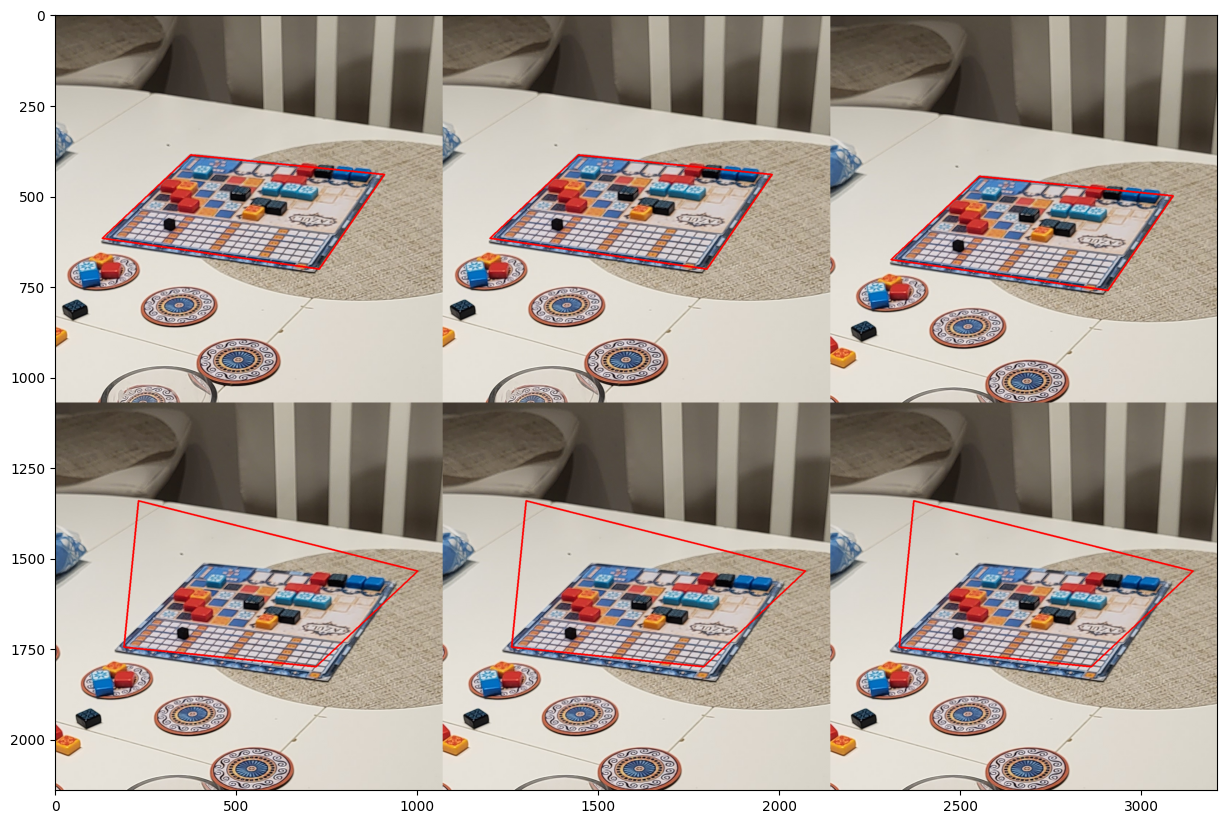

In [107]:
ptsj = pts[2] 
sz = np.diff(ptsj, axis=0).max() * 1

d = vision.BoardDetector_ORB(SHAPE_OUT=(s, s), PATCH_SIZE=s//10, N_FEATURES=3_000)


# cv2.polylines(imgDraw, [ptsj.astype(np.int32)], True, (0,0,255), 11)
imgDebug = []

for rep in range(6):
    imgDraw = img.copy()
    cv2.polylines(imgDraw, [ptsj.astype(np.int32)], True, (0,0,255), 3)

    matLabel = cv2.getPerspectiveTransform(np.float32(ptsj), np.float32(dst)) 
    imgWarped = cv2.warpPerspective(img, matLabel, (s,s))

    try:
        matORB = d.get_matrix(imgWarped, True)

        pts2 = cv2.perspectiveTransform(
            np.float32(kps).reshape(-1,1,2), 
            np.linalg.inv(matORB @ matLabel))
        ptsj = pts2[[0, 1, 3, 2], 0, :]
        print("ok!")

    except Exception as e:
        print("Fail!")
        print(e)
        # throw exception

    c0 = np.mean(ptsj, axis=0).astype(np.int32)
    imgDebug.append(imgDraw[c0[1]-sz:c0[1]+sz, c0[0]-sz:c0[0]+sz, :])

        # pass
# imgDebug = np.concatenate(imgDebug, axis=0)
imgDebug = vision.tile(imgDebug)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(imgDebug, cv2.COLOR_BGR2RGB));
# plt.imshow(cv2.cvtColor(imgWarped, cv2.COLOR_BGR2RGB));
# pathLbl

In [86]:
c0

array([729, 120], dtype=int32)

In [74]:
from ultralytics import YOLO
import cv2 
import matplotlib.pyplot as plt
 
# Load the model.
model = YOLO('yolov8n-seg.pt')

# Training.
results = model.train(
   data='/home/garamizo/Datasets/azul_segmentation_finetune/data.yaml',
   imgsz=640,
   epochs=120,
   batch=8,
   name='yolov8n_azul',
   single_cls=True,
   pretrained=False,
   translate=0.3,
   degrees=10,
   scale=0.2,
   perspective=0.0005,
   shear=5,
   fliplr=0.0,
   flipud=0.0,
   mixup=0.0,
   mosaic=0.0,
   copy_paste=0.1,
)

Ultralytics YOLOv8.0.230 🚀 Python-3.8.10 torch-1.13.0+cu117 CPU (Intel Core(TM) i5-1035G1 1.00GHz)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/home/garamizo/Datasets/azul_segmentation_finetune/data.yaml, epochs=120, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_azul16, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_

train: Scanning /home/garamizo/Datasets/azul_segmentation_finetune/train/labels... 40 images, 1 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 1281.88it/s]

train: New cache created: /home/garamizo/Datasets/azul_segmentation_finetune/train/labels.cache



val: Scanning /home/garamizo/Datasets/azul_segmentation_finetune/valid/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 1803.61it/s]

val: New cache created: /home/garamizo/Datasets/azul_segmentation_finetune/valid/labels.cache
Plotting labels to runs/segment/yolov8n_azul16/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
120 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/120         0G     0.5524      1.431      2.562     0.9321          4        640: 100%|██████████| 6/6 [01:00<00:00, 10.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]

                   all          8         30     0.0125          1      0.631      0.551     0.0125          1      0.627      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/120         0G      0.381     0.5373      1.716     0.8375          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

                   all          8         30          1      0.531       0.99       0.88          1      0.531       0.99       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/120         0G     0.3998     0.3741     0.9924     0.8174          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]

                   all          8         30      0.996      0.967      0.994      0.828      0.996      0.967      0.994      0.948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/120         0G     0.3907     0.4185     0.8378     0.8475          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

                   all          8         30          1      0.999      0.995      0.866          1      0.999      0.995      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/120         0G     0.5101     0.4095     0.8709     0.8383          4        640: 100%|██████████| 6/6 [00:17<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

                   all          8         30      0.998      0.967       0.99      0.886      0.998      0.967       0.99      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/120         0G     0.4953     0.3121     0.7914     0.8249          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]

                   all          8         30          1      0.966       0.99      0.863          1      0.966       0.99      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/120         0G     0.4531     0.2984     0.7437     0.8249          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

                   all          8         30      0.998      0.967      0.993      0.899      0.998      0.967      0.993      0.978



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/120         0G     0.4898     0.3107     0.7964     0.8269          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]

                   all          8         30          1          1      0.995      0.885          1          1      0.995      0.981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/120         0G     0.4442      0.313     0.7458      0.824          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]

                   all          8         30      0.993          1      0.995      0.874      0.993          1      0.995      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/120         0G     0.5133     0.3885     0.7925     0.8799          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]

                   all          8         30          1      0.964      0.994      0.869          1      0.964      0.994      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/120         0G     0.5194     0.4357     0.8048     0.8474          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

                   all          8         30      0.994      0.933      0.989      0.839      0.994      0.933      0.989      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/120         0G     0.4724     0.2701     0.7444     0.8481          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

                   all          8         30      0.994      0.933      0.973      0.866      0.994      0.933      0.973      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/120         0G     0.4063     0.2773     0.6966     0.8454          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

                   all          8         30      0.966      0.949      0.964       0.89      0.966      0.949      0.964      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/120         0G     0.5057     0.2938     0.8823     0.8319          2        640: 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]

                   all          8         30          1      0.921      0.976      0.842          1      0.921      0.976       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/120         0G     0.4922      0.283     0.6954     0.8334          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all          8         30          1      0.921      0.976      0.842          1      0.921      0.976       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/120         0G     0.5397     0.2744     0.7632     0.8468          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]

                   all          8         30          1      0.892       0.98      0.809          1      0.892       0.98      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/120         0G     0.4721     0.2851      1.023     0.8547          1        640: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

                   all          8         30      0.963      0.933      0.985      0.854      0.963      0.933      0.985       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/120         0G     0.5318      0.279     0.7039     0.8541          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]

                   all          8         30          1      0.931      0.985      0.858          1      0.931      0.985      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/120         0G     0.5423     0.3056     0.7154     0.8396          4        640: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]

                   all          8         30          1      0.931      0.985      0.858          1      0.931      0.985      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/120         0G     0.5056      0.341      1.008     0.8285          1        640: 100%|██████████| 6/6 [00:18<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

                   all          8         30      0.997      0.933      0.989      0.861      0.997      0.933      0.989      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/120         0G     0.5488     0.3468     0.7028     0.8544          4        640: 100%|██████████| 6/6 [00:17<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

                   all          8         30          1      0.963      0.991      0.835          1      0.963      0.991      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/120         0G     0.5685     0.3443     0.6997      0.893          3        640: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]

                   all          8         30      0.998      0.933       0.99      0.878      0.998      0.933       0.99      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/120         0G     0.4731     0.2986      0.645     0.8494          3        640: 100%|██████████| 6/6 [00:17<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]

                   all          8         30      0.998      0.933       0.99      0.878      0.998      0.933       0.99      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/120         0G     0.5108     0.3538     0.6914     0.8377          3        640: 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

                   all          8         30      0.998      0.933      0.985      0.885      0.998      0.933      0.985      0.952



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/120         0G      0.518     0.2889     0.6511     0.8313          4        640: 100%|██████████| 6/6 [00:18<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

                   all          8         30      0.998      0.933      0.978      0.873      0.998      0.933      0.978      0.944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/120         0G      0.476     0.2849     0.6419     0.8549          3        640: 100%|██████████| 6/6 [00:16<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]

                   all          8         30      0.998      0.933      0.966      0.885      0.998      0.933      0.966      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/120         0G     0.4903     0.2805     0.6061     0.8433          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]

                   all          8         30      0.998      0.933      0.966      0.885      0.998      0.933      0.966      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/120         0G     0.5816     0.3589     0.7163     0.8729          2        640: 100%|██████████| 6/6 [00:16<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

                   all          8         30      0.998      0.933      0.968      0.857      0.998      0.933      0.968      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/120         0G     0.5238     0.3074     0.6737     0.8602          4        640: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]

                   all          8         30          1      0.933      0.961      0.852          1      0.933      0.961      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/120         0G      0.491     0.2951     0.6494     0.8596          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

                   all          8         30      0.994      0.867      0.954      0.835      0.994      0.867      0.953      0.846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/120         0G     0.5363     0.3164     0.6083     0.8604          4        640: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]

                   all          8         30      0.994      0.867      0.954      0.835      0.994      0.867      0.953      0.846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/120         0G     0.5733     0.3314     0.6469     0.8643          4        640: 100%|██████████| 6/6 [00:17<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]

                   all          8         30          1      0.929      0.961      0.843          1      0.929      0.959      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/120         0G     0.5771     0.3534     0.6514      0.855          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all          8         30      0.998      0.933      0.945      0.843      0.998      0.933      0.941      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/120         0G      0.522     0.3132     0.6434     0.8547          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]

                   all          8         30          1      0.931       0.94       0.86      0.997        0.9      0.906      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/120         0G     0.4913     0.2875      0.602     0.8394          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]

                   all          8         30          1      0.931       0.94       0.86      0.997        0.9      0.906      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/120         0G     0.4897      0.283     0.9559     0.8808          1        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all          8         30      0.997        0.9       0.94      0.824      0.997        0.9      0.904        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/120         0G     0.5147     0.2907     0.6401     0.8671          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all          8         30          1      0.931      0.947      0.848          1      0.931      0.946      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/120         0G     0.4926      0.277     0.6114     0.8198          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all          8         30          1      0.932      0.949       0.84          1      0.932      0.949      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/120         0G     0.5051     0.2914      0.636     0.8361          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]

                   all          8         30          1      0.932      0.949       0.84          1      0.932      0.949      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/120         0G     0.4511     0.2692      0.584     0.8495          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

                   all          8         30          1      0.932      0.953      0.854          1      0.932      0.949      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/120         0G     0.4303     0.2438      0.579     0.8228          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all          8         30          1      0.932      0.958      0.879          1      0.932      0.954      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/120         0G     0.5273     0.3408     0.6431     0.8487          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all          8         30          1      0.933      0.958      0.863          1      0.933      0.955       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/120         0G     0.4591     0.2911     0.5749     0.8468          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

                   all          8         30          1      0.933      0.958      0.863          1      0.933      0.955       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/120         0G     0.4111     0.2347     0.5595     0.8353          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

                   all          8         30          1      0.933      0.956      0.861          1      0.933      0.952      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/120         0G     0.4062     0.2327     0.5593     0.8377          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all          8         30      0.998      0.933      0.951      0.869      0.998      0.933      0.951      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/120         0G     0.4567     0.2709      0.565     0.8174          2        640: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all          8         30      0.997      0.933      0.952      0.895      0.997      0.933      0.948      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/120         0G     0.4912     0.3682     0.6372     0.8354          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all          8         30      0.997      0.933      0.952      0.895      0.997      0.933      0.948      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/120         0G     0.4619     0.2587     0.5744     0.8393          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all          8         30      0.998      0.933      0.953      0.874      0.998      0.933      0.953      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/120         0G     0.4447     0.2578     0.5538     0.8373          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all          8         30      0.998      0.933       0.98      0.899      0.998      0.933       0.98      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/120         0G     0.4947     0.2828     0.5564     0.8669          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all          8         30      0.998      0.933      0.986      0.909      0.998      0.933      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/120         0G     0.4562     0.2639     0.5352     0.8738          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all          8         30      0.998      0.933      0.986      0.909      0.998      0.933      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/120         0G     0.4391     0.3363     0.5178     0.8241          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

                   all          8         30      0.999      0.967       0.99      0.924      0.999      0.967       0.99      0.974



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/120         0G     0.4229     0.2549     0.5348     0.8373          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all          8         30          1      0.966      0.983       0.89          1      0.966      0.983      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/120         0G     0.4337     0.2765     0.5158     0.8511          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all          8         30      0.998      0.933      0.965      0.882      0.998      0.933      0.961      0.947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/120         0G     0.4044     0.2884     0.5183     0.7999          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

                   all          8         30      0.998      0.933      0.965      0.882      0.998      0.933      0.961      0.947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/120         0G     0.4586       0.41     0.5467     0.8582          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all          8         30      0.998      0.933      0.953      0.869      0.998      0.933      0.949      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/120         0G     0.4123     0.2364     0.5239     0.8315          3        640: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all          8         30      0.998      0.933      0.945      0.853      0.998      0.933      0.945      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/120         0G     0.4185     0.2688     0.5055     0.8427          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all          8         30          1      0.929      0.939      0.877          1      0.929      0.938      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/120         0G     0.4014     0.2299     0.5106     0.8539          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

                   all          8         30          1      0.929      0.939      0.877          1      0.929      0.938      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/120         0G     0.4342     0.2818     0.5021     0.8436          3        640: 100%|██████████| 6/6 [00:14<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all          8         30      0.999        0.9      0.898      0.817      0.999        0.9      0.898      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/120         0G     0.4004     0.2379     0.4904     0.8209          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

                   all          8         30          1      0.899      0.901      0.815          1      0.899      0.901      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/120         0G     0.4635     0.3124     0.5341      0.851          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

                   all          8         30          1      0.932      0.937      0.857          1      0.932      0.935      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/120         0G     0.3758     0.2105     0.5025     0.8331          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

                   all          8         30          1      0.932      0.937      0.857          1      0.932      0.935      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/120         0G     0.3983     0.2481     0.5848     0.8385          2        640: 100%|██████████| 6/6 [00:14<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all          8         30          1      0.932      0.943       0.86          1      0.932      0.944      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/120         0G      0.397     0.2817     0.4933     0.8331          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all          8         30      0.993      0.967      0.994      0.927      0.993      0.967      0.994      0.975



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/120         0G     0.3642     0.2197     0.5048     0.8334          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

                   all          8         30          1          1      0.995      0.934          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/120         0G     0.3916     0.2173     0.4857     0.8414          3        640: 100%|██████████| 6/6 [00:14<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all          8         30          1          1      0.995      0.934          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/120         0G      0.412     0.2669     0.5139     0.8461          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

                   all          8         30      0.997          1      0.995      0.924      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/120         0G     0.3626     0.2594     0.4891     0.8218          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all          8         30      0.998          1      0.995       0.94      0.998          1      0.995      0.989



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/120         0G     0.4141     0.2397     0.4862     0.8139          3        640: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all          8         30      0.997          1      0.995      0.934      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/120         0G      0.416     0.2228     0.4903     0.8063          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

                   all          8         30      0.997          1      0.995      0.934      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/120         0G     0.3864     0.2137      0.491     0.8048          3        640: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

                   all          8         30          1      0.996      0.995      0.928          1      0.996      0.995      0.981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/120         0G     0.3234     0.2221      4.095     0.6889          0        640: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

                   all          8         30      0.996      0.967      0.994      0.925      0.996      0.967      0.994      0.976



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/120         0G     0.4023     0.2442      0.474     0.8069          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all          8         30      0.999      0.967      0.989      0.909      0.999      0.967      0.989      0.976



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/120         0G     0.3662     0.2282     0.4848     0.8603          3        640: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all          8         30      0.999      0.967      0.989      0.909      0.999      0.967      0.989      0.976



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/120         0G     0.3836     0.3145     0.4848     0.8209          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

                   all          8         30          1      0.966      0.991      0.912          1      0.966      0.991      0.982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/120         0G     0.4277     0.2869     0.4832     0.8263          4        640: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all          8         30          1      0.996      0.995       0.94          1      0.996      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/120         0G     0.3906      0.313     0.4928     0.8459          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all          8         30      0.998          1      0.995      0.951      0.998          1      0.995      0.972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/120         0G      0.385     0.3067     0.4853     0.8362          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all          8         30      0.998          1      0.995      0.951      0.998          1      0.995      0.972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/120         0G     0.3704     0.2118     0.4526     0.8335          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

                   all          8         30      0.998          1      0.995      0.957      0.998          1      0.995      0.979



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/120         0G     0.3768     0.2105     0.4426     0.8478          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all          8         30      0.998          1      0.995      0.957      0.998          1      0.995      0.979



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/120         0G      0.375     0.2204     0.4396     0.8001          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

                   all          8         30      0.998          1      0.995      0.955      0.998          1      0.995      0.979



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/120         0G     0.3689     0.2619     0.4444     0.8199          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

                   all          8         30      0.998          1      0.995      0.955      0.998          1      0.995      0.979



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/120         0G     0.3832     0.1976     0.4363      0.828          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all          8         30      0.997          1      0.995       0.93      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/120         0G      0.363     0.2163     0.4163     0.8021          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all          8         30      0.997          1      0.995      0.962      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/120         0G     0.3548      0.221     0.4275     0.7998          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all          8         30      0.997          1      0.995      0.971      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/120         0G     0.3815     0.2482     0.4558     0.8033          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]

                   all          8         30      0.997          1      0.995      0.971      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/120         0G     0.3443     0.2162     0.4156     0.8145          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all          8         30      0.998          1      0.995      0.965      0.998          1      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/120         0G     0.3752     0.2309     0.4516     0.8141          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all          8         30      0.999          1      0.995      0.966      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/120         0G     0.3483     0.1827     0.6531     0.8005          1        640: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all          8         30      0.999          1      0.995      0.946      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/120         0G     0.3404     0.2106     0.4431     0.7865          2        640: 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

                   all          8         30      0.999          1      0.995      0.946      0.999          1      0.995      0.985



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/120         0G     0.3924     0.2606     0.4663     0.8544          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all          8         30      0.999          1      0.995      0.961      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/120         0G     0.3569     0.2301     0.4449      0.838          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

                   all          8         30      0.998          1      0.995      0.954      0.998          1      0.995      0.989



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/120         0G     0.3605     0.2691     0.4192     0.8374          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all          8         30      0.997          1      0.995      0.954      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/120         0G     0.3184     0.1879     0.3982     0.8144          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all          8         30      0.997          1      0.995      0.954      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/120         0G     0.3272     0.2094     0.3967     0.8072          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all          8         30      0.997          1      0.995      0.949      0.997          1      0.995      0.979



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/120         0G      0.337     0.2383     0.3979     0.8004          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]

                   all          8         30      0.997          1      0.995      0.961      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/120         0G     0.3421     0.2069     0.3942     0.7758          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all          8         30      0.998          1      0.995      0.962      0.998          1      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/120         0G     0.3348     0.2217     0.4281     0.7888          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

                   all          8         30      0.998          1      0.995      0.962      0.998          1      0.995       0.98



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/120         0G     0.2997     0.1986      0.385     0.7931          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all          8         30      0.998          1      0.995      0.958      0.998          1      0.995      0.981



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/120         0G     0.3384     0.2333     0.3938     0.8385          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all          8         30      0.998          1      0.995      0.965      0.998          1      0.995      0.982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/120         0G     0.2982     0.1779     0.3648     0.8027          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all          8         30      0.998          1      0.995      0.978      0.998          1      0.995      0.982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/120         0G     0.3028     0.1964     0.3634     0.8141          3        640: 100%|██████████| 6/6 [00:16<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all          8         30      0.998          1      0.995      0.978      0.998          1      0.995      0.982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/120         0G     0.2924     0.1883     0.3644     0.7966          3        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

                   all          8         30      0.998          1      0.995      0.983      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/120         0G     0.3222     0.2108     0.3798      0.824          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all          8         30      0.998          1      0.995      0.973      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/120         0G     0.3114     0.1815     0.4278     0.8098          2        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all          8         30      0.998          1      0.995      0.978      0.998          1      0.995      0.983



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/120         0G     0.2394     0.1706      4.902     0.6785          0        640: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

                   all          8         30      0.998          1      0.995      0.978      0.998          1      0.995      0.983



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/120         0G     0.2469     0.1739      5.742     0.6654          0        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all          8         30      0.998          1      0.995      0.977      0.998          1      0.995      0.984



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/120         0G     0.2974     0.1966     0.4331     0.8126          2        640: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

                   all          8         30      0.998          1      0.995      0.972      0.998          1      0.995      0.984



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/120         0G     0.2817      0.206     0.3576      0.787          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all          8         30      0.998          1      0.995      0.977      0.998          1      0.995      0.985


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/120         0G       0.29     0.1997     0.3587     0.8081          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all          8         30      0.998          1      0.995      0.977      0.998          1      0.995      0.985



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/120         0G     0.2624     0.1911     0.3684     0.7945          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

                   all          8         30      0.998          1      0.995      0.971      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/120         0G     0.2808     0.1879     0.3548      0.783          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

                   all          8         30      0.998          1      0.995      0.972      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/120         0G      0.302     0.2036     0.3465     0.7929          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all          8         30      0.998          1      0.995      0.979      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/120         0G     0.2825     0.1963       0.36     0.8189          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all          8         30      0.998          1      0.995      0.979      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/120         0G     0.2587     0.1772     0.3539     0.7956          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all          8         30      0.998          1      0.995      0.983      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/120         0G     0.2742      0.182     0.3551     0.8123          3        640: 100%|██████████| 6/6 [00:16<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all          8         30      0.998          1      0.995      0.983      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/120         0G      0.255     0.1786     0.3405     0.8129          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

                   all          8         30      0.998          1      0.995      0.983      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/120         0G     0.2726     0.1944     0.3589     0.8257          4        640: 100%|██████████| 6/6 [00:16<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all          8         30      0.998          1      0.995      0.983      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/120         0G     0.2786     0.2079     0.3462     0.8061          4        640: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

                   all          8         30      0.998          1      0.995      0.983      0.998          1      0.995      0.986



120 epochs completed in 0.651 hours.
Optimizer stripped from runs/segment/yolov8n_azul16/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/yolov8n_azul16/weights/best.pt, 6.8MB

Validating runs/segment/yolov8n_azul16/weights/best.pt...
Ultralytics YOLOv8.0.230 🚀 Python-3.8.10 torch-1.13.0+cu117 CPU (Intel Core(TM) i5-1035G1 1.00GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


                   all          8         30      0.998          1      0.995      0.983      0.998          1      0.995      0.986
Speed: 1.3ms preprocess, 104.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/segment/yolov8n_azul16


In [3]:
from ultralytics import YOLO
import cv2 
import matplotlib.pyplot as plt
 
# Load the model.
model = YOLO('yolov8s-pose.pt')

# yolo pose train data='/home/garamizo/Datasets/project-4-at-2023-09-02-19-51-b3ad348e_pose/data_pose.yaml' model=yolov8s-pose.yaml pretrained=yolov8s-pose.pt epochs=15


# Training.
results = model.train(
   data='/home/garamizo/Datasets/project-4-at-2023-09-02-19-51-b3ad348e_pose/data_pose.yaml',
   # imgsz=640,
   epochs=100,
   batch=8,
   name='yolov8s_azul',
   single_cls=True,
   pretrained=False,
   translate=0.3,
   degrees=10,
   scale=0.2,
   perspective=0.0005,
   shear=5,
   fliplr=0.0,
   flipud=0.0,
   mixup=0.0,
   mosaic=0.0,
   copy_paste=0.1,
)

New https://pypi.org/project/ultralytics/8.0.230 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.109 🚀 Python-3.8.10 torch-1.13.0+cu117 CPU
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=/home/garamizo/Datasets/project-4-at-2023-09-02-19-51-b3ad348e_pose/data_pose.yaml, epochs=200, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_azul, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line

: 

[[[     1500.9      2060.1]]

 [[     2239.1      2031.2]]

 [[     2317.7      2784.8]]

 [[       1451      2835.4]]]


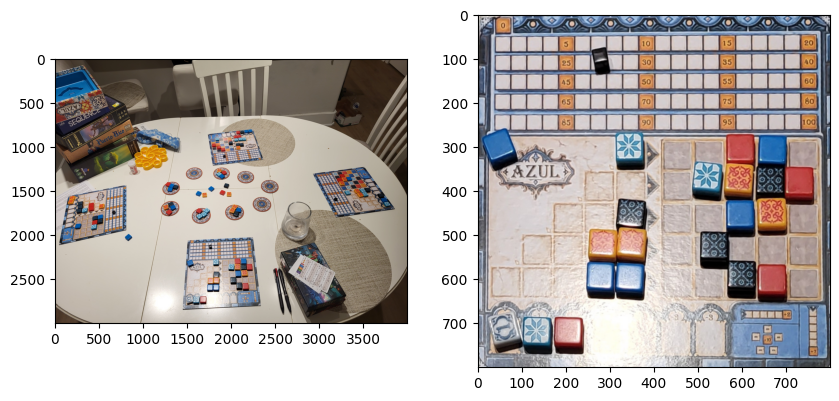

In [104]:
# pts2 = cv2.perspectiveTransform(
#     np.float32([[2000, 2000]]).reshape(-1,1,2), matORB @ matLabel)
# print(pts2)

pts2 = cv2.perspectiveTransform(
    np.float32([[0, 0], [s, 0], [s, s], [0, s]]).reshape(-1,1,2), np.linalg.inv(matORB @ matLabel))
print(pts2)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
plt.subplot(122), plt.imshow(cv2.cvtColor(imgWarped2, cv2.COLOR_BGR2RGB));

In [69]:
pts[0].shape

(4, 2)

In [47]:
labels[0].shape

(4, 2)